In [1]:
import os
import kagglehub
import pandas as pd
import joblib

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import mlflow
from imblearn.over_sampling import SMOTE

c:\Users\Minfy\Desktop\MLFLOW\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5000")

In [2]:
# Save dir
import os
SAVEDIR = os.getenv('ARTIFACT_DIR', '.') + '/saved_models'
os.makedirs(SAVEDIR, exist_ok=True)

def load_data():
    path = kagglehub.dataset_download("itsmesunil/bank-loan-modelling")
    df = pd.read_excel(
        os.path.join(path, "Bank_Personal_Loan_Modelling.xlsx"),
        sheet_name='Data'
    )
    # DROP via keyword axis=
    return df.drop(['ID', 'ZIP Code'], axis=1)


In [3]:
def split_data(df):
    X = df.drop('Personal Loan', axis=1)
    y = df['Personal Loan']
    X0, X_test, y0, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X0, y0, test_size=0.2, stratify=y0, random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
def preprocess_fit(X_train, X_val, X_test):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import skew

    rb = ['CCAvg','Mortgage']
    st = ['Income','Experience','Age']

    # === 1. Skewness Check ===
    print("\n📈 Skewness Before Transformation:")
    skew_vals = X_train[rb + st].apply(skew)
    print(skew_vals)

    # === 2. Histograms Before Transformation ===
    X_train[rb + st].hist(bins=30, figsize=(12, 8), color='skyblue', edgecolor='black')
    plt.suptitle("Histograms Before Transformation", fontsize=16)
    plt.tight_layout()
    plt.show()

    # === 3. Boxplots Before Transformation ===
    plt.figure(figsize=(15, 6))
    for i, col in enumerate(rb + st, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(y=X_train[col], color='lightcoral')
        plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

    # === 4. Preprocessing Steps ===
    pt = PowerTransformer('yeo-johnson')
    rs = RobustScaler()
    ss = StandardScaler()

    X_train[rb] = rs.fit_transform(pt.fit_transform(X_train[rb]))
    X_train[st] = ss.fit_transform(X_train[st])

    for X in (X_val, X_test):
        X[rb] = rs.transform(pt.transform(X[rb]))
        X[st] = ss.transform(X[st])

    joblib.dump(pt, os.path.join(SAVEDIR, 'pt.pkl'))
    joblib.dump(rs, os.path.join(SAVEDIR, 'rs.pkl'))
    joblib.dump(ss, os.path.join(SAVEDIR, 'ss.pkl'))

    return X_train, X_val, X_test

In [5]:
def feature_select_fit(X_train, y_train, X_val, X_test):
    selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=8)
    Xtr = selector.fit_transform(X_train, y_train)
    Xv  = selector.transform(X_val)
    Xt  = selector.transform(X_test)
    joblib.dump(selector, os.path.join(SAVEDIR, 'selector.pkl'))
    return Xtr, Xv, Xt

In [6]:
def balance(X, y):
    sm = SMOTE(random_state=42)
    return sm.fit_resample(X, y)

In [7]:
import os
import time
import joblib
import mlflow
import mlflow.sklearn
import yaml
from mlflow.tracking import MlflowClient
from mlflow.entities import Metric
from mlflow.utils.yaml_utils import YamlSafeDumper
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ─── 1) Patch MLflow’s YAML dumper so any object is stringified ─────────────
# Catch Metric explicitly
YamlSafeDumper.add_multi_representer(
    Metric,
    lambda dumper, metric: dumper.represent_scalar(
        'tag:yaml.org,2002:str',
        f"{metric.key}={metric.value:.6f}@{metric.timestamp}"
    )
)
# Catch _everything else_ so nothing breaks
YamlSafeDumper.add_multi_representer(
    object,
    lambda dumper, obj: dumper.represent_scalar(
        'tag:yaml.org,2002:str',
        str(obj)
    )
)

# ─── 2) Setup local‐save directory ─────────────────────────────────────────────
SAVEDIR = "saved_models"
os.makedirs(SAVEDIR, exist_ok=True)

def tune_and_save(X, y, X_val, y_val):
    mlflow.set_experiment("Bank Loan Classification")
    client = MlflowClient()

    best_f1 = 0.0
    best_model_name = None
    best_model_path = None

    grids = {
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {'C': [0.01, 0.1, 1, 10],
                       'penalty': ['l1', 'l2'],
                       'solver': ['liblinear']}
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(),
            'params': {'max_depth': [3, 5, 7, None],
                       'min_samples_split': [2, 5, 10],
                       'min_samples_leaf': [1, 2, 4]}
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {'n_estimators': [50, 100],
                       'max_depth': [5, 10, None]}
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {'n_estimators': [50, 100],
                       'learning_rate': [0.01, 0.1]}
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {'n_neighbors': [3, 5, 7]}
        },
        'SVM': {
            'model': SVC(probability=True, random_state=42),
            'params': {'C': [0.1, 1, 10],
                       'kernel': ['linear', 'rbf']}
        }
    }

    for name, cfg in grids.items():
        with mlflow.start_run(run_name=name, nested=True) as run:
            # Not using broad autolog to avoid unexpected objects
            # mlflow.sklearn.autolog(log_models=True, log_input_examples=False)

            gs = GridSearchCV(cfg['model'], cfg['params'], scoring='f1',
                              cv=5, n_jobs=-1)
            gs.fit(X, y)
            best_model = gs.best_estimator_

            preds = best_model.predict(X_val)
            acc = accuracy_score(y_val, preds)
            prec = precision_score(y_val, preds)
            rec = recall_score(y_val, preds)
            f1 = f1_score(y_val, preds)

            # Only primitive metric logging
            mlflow.log_metrics({
                "val_accuracy": acc,
                "val_precision": prec,
                "val_recall": rec,
                "val_f1": f1
            })

            print(f"{name} tuned → {gs.best_params_}")
            print(f"→ Accuracy: {acc:.3f}, Precision: {prec:.3f}, "
                  f"Recall: {rec:.3f}, F1: {f1:.3f}")

            # Save locally and log artifact
            local_path = os.path.join(SAVEDIR, f"{name}_model.pkl")
            joblib.dump(best_model, local_path)
            mlflow.sklearn.log_model(best_model, artifact_path="model")

            if f1 > best_f1:
                best_f1 = f1
                best_model_name = name
                best_model_path = f"runs:/{run.info.run_id}/model"

    # Register & promote to Production
    if best_model_name and best_model_path:
        print(f"\n🏆 Registering best model: {best_model_name} (F1={best_f1:.3f})")
        mv = mlflow.register_model(
            model_uri=best_model_path,
            name="BankLoanBestModel"
        )
        print(f"✅ Registered: {mv.name}, version {mv.version}")

        # Wait for registry metadata to be ready
        for _ in range(15):
            info = client.get_model_version(name=mv.name, version=mv.version)
            if info.status == "READY":
                break
            time.sleep(1)

        client.transition_model_version_stage(
            name=mv.name,
            version=mv.version,
            stage="Production",
            archive_existing_versions=True
        )
        print(f"🚀 {mv.name} v{mv.version} → Production")

In [8]:
def main():
    mlflow.set_experiment("Bank Loan Classification")

    with mlflow.start_run(run_name="Preprocessing and Tuning"):
        df = load_data()
        Xtr, Xv, Xt, ytr, yv, yt = split_data(df)
        Xtr, Xv, Xt = preprocess_fit(Xtr, Xv, Xt)
        Xtf, Xvf, Xsf = feature_select_fit(Xtr, ytr, Xv, Xt)

        # Log preprocessing artifacts
        for file in ['pt.pkl', 'rs.pkl', 'ss.pkl', 'selector.pkl']:
            mlflow.log_artifact(os.path.join(SAVEDIR, file))

        Xb, yb = balance(Xtf, ytr)
        tune_and_save(Xb, yb, Xvf, yv)

In [9]:
def main():
    mlflow.set_experiment("Minfy_MLFLOW_EXP")

    with mlflow.start_run(run_name="Preprocessing and Tuning"):
        df = load_data()
        Xtr, Xv, Xt, ytr, yv, yt = split_data(df)
        Xtr, Xv, Xt = preprocess_fit(Xtr, Xv, Xt)
        Xtf, Xvf, Xsf = feature_select_fit(Xtr, ytr, Xv, Xt)

        # Log preprocessing artifacts
        for file in ['pt.pkl', 'rs.pkl', 'ss.pkl', 'selector.pkl']:
            mlflow.log_artifact(os.path.join(SAVEDIR, file))

        Xb, yb = balance(Xtf, ytr)
        tune_and_save(Xb, yb, Xvf, yv)



📈 Skewness Before Transformation:
CCAvg         1.617504
Mortgage      2.174653
Income        0.835293
Experience   -0.043929
Age          -0.048283
dtype: float64


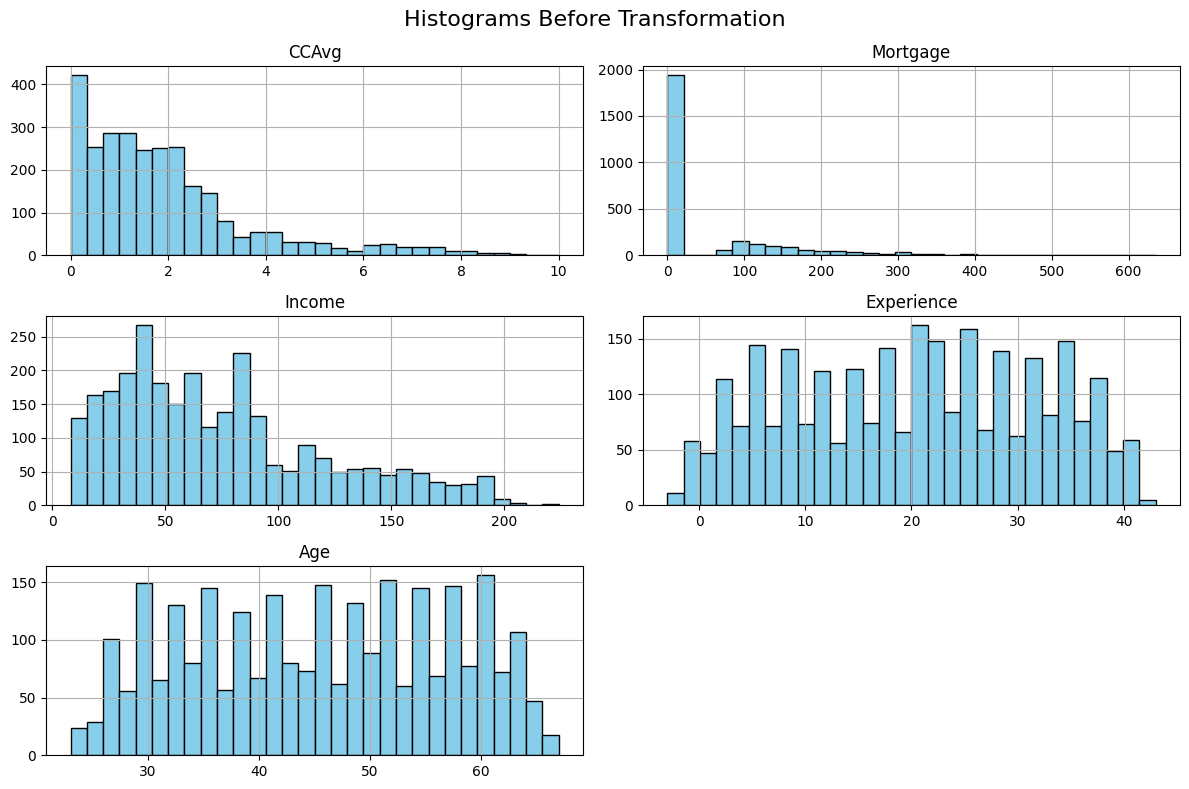

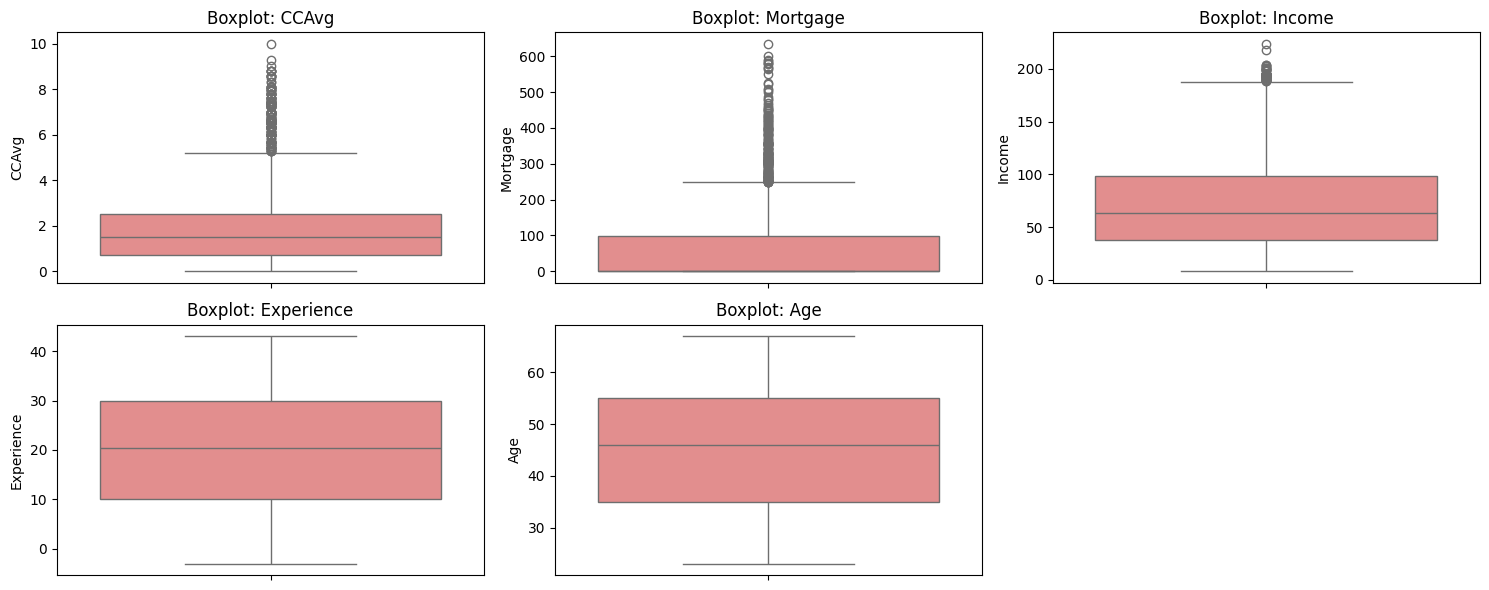

MlflowException: When an mlflow-artifacts URI was supplied, the tracking URI must be a valid http or https URI, but it was currently set to file:///c:/Users/Minfy/Desktop/MLFLOW/myenv/mlruns. Perhaps you forgot to set the tracking URI to the running MLflow server. To set the tracking URI, use either of the following methods:
1. Set the MLFLOW_TRACKING_URI environment variable to the desired tracking URI. `export MLFLOW_TRACKING_URI=http://localhost:5000`
2. Set the tracking URI programmatically by calling `mlflow.set_tracking_uri`. `mlflow.set_tracking_uri('http://localhost:5000')`

In [10]:
if __name__=='__main__':
    main()